In [50]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
from utils import filt_decompose


In [3]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'


In [35]:
# Load raw csv
year='2023'
infile = f'NRA_airgap_RAW_{year}.csv.gz'

# year='2024_0525'
# infile = 'NRA raw wave radar 202401 - 202505.csv.gz'

###

csvfile = f'/data/TIDE/NRA/{infile}'
df = pd.read_csv(csvfile, header=7, 
                 #nrows = 31*2*86400,
                 parse_dates=True,
                 sep=',', index_col=0, compression='gzip')

df.rename(columns={'6ee24280-dc14-11ea-ab29-07bcbab2eee7': 'airgap'}, inplace=True)
df.rename(columns={'6ee24280-dc14-11ea-ab29-07bcbab2eee7.1': 'airgap_flag'}, inplace=True)
df
ds = df.to_xarray()
ds


<xarray.Dataset> Size: 1GB
Dimensions:            (Timestamp (UTC+8): 62855825)
Coordinates:
  * Timestamp (UTC+8)  (Timestamp (UTC+8)) datetime64[ns] 503MB 2023-01-01T00...
Data variables:
    airgap             (Timestamp (UTC+8)) float64 503MB 26.49 26.73 ... 24.96

In [36]:
%%time
ds.to_netcdf(f'/data/TIDE/NRA/NRA_airgap_RAW_{year}.nc',
    encoding={'airgap':{"compression": "zlib", "complevel": 9}})

CPU times: user 1min 8s, sys: 1.34 s, total: 1min 9s
Wall time: 1min 10s


In [37]:
ds = xr.open_dataset(f'/data/TIDE/NRA/NRA_airgap_RAW_{year}.nc')

In [38]:
#ds['airgap'].plot(lw=0.2)

In [39]:
time = ds['Timestamp (UTC+8)'].values

dt = (time[1:]-time[:-1]).mean()
dtsec = dt.astype(float)*1e-9
dtsec, 1/dtsec

(np.float64(0.500345035), np.float64(1.9986208117364448))

In [40]:
tfloat = time.astype(float)
tfloat[1:] - tfloat[0:-1]

array([5.00000000e+08, 5.00000000e+08, 5.00000000e+08, ...,
       5.00000000e+08, 5.00000000e+08, 5.09999872e+08], shape=(62855824,))

In [41]:
#filt_decompose?

In [42]:
# dtsec = 0.5
# y = ds['airgap']-ds['airgap'].mean()
# yf = filt_decompose(y, 1/dtsec, b1=8*3600, b2=120)

# ss = 120
# plt.figure()
# plt.plot(time[::ss], yf[::ss,0], lw=0.2)
# plt.xticks(rotation=17)

In [43]:
%%time
#y = ds['airgap'] #-ds['airgap'].mean()
yf = ds['airgap'].resample({'Timestamp (UTC+8)':'60s'}).mean()

#yf.plot()
#y.shape, yf.shape
yf.shape
# plt.xlim(np.datetime64('2023-01-07 15:00:00'), np.datetime64('2023-01-07 18:00:00'))

CPU times: user 3min 3s, sys: 1.37 s, total: 3min 5s
Wall time: 3min 5s


(524160,)

In [48]:
%%time
#yflag = ds['airgap_flag'].resample({'Timestamp (UTC+8)':'60s'}).min()
#yflag.plot()

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.25 μs


In [49]:
# Create a down-scaled output dataset
#dsout = xr.DataArray(yf[::ss,0]+yf[::ss,1], coords={'time':time[::ss]})
#xr.Dataset({'airgap':dsout}).to_netcdf(f'/data/TIDE/NRA/NRA_airgap_RAW_{year}_60s.nc')
#dsout = xr.Dataset({'airgap':yf, 'airgap_flag':yflag})
dsout = xr.Dataset({'airgap':yf,})

dsout.to_netcdf(f'/data/TIDE/NRA/NRA_airgap_RAW_{year}_60s.nc')

dsout

<xarray.Dataset> Size: 8MB
Dimensions:            (Timestamp (UTC+8): 524160)
Coordinates:
  * Timestamp (UTC+8)  (Timestamp (UTC+8)) datetime64[ns] 4MB 2023-01-01 ... ...
Data variables:
    airgap             (Timestamp (UTC+8)) float64 4MB 26.28 26.28 ... 24.83

In [29]:
# Convert to sea surface height

<xarray.DataArray 'airgap' (time: 710813)> Size: 6MB
array([ 0.79192192,  0.81983025,  0.88781359, ..., -0.33158641,
       -0.33280308, -0.31030043], shape=(710813,))
Coordinates:
  * time     (time) datetime64[ns] 6MB 2023-12-31T16:00:00 ... 2025-05-08T06:...

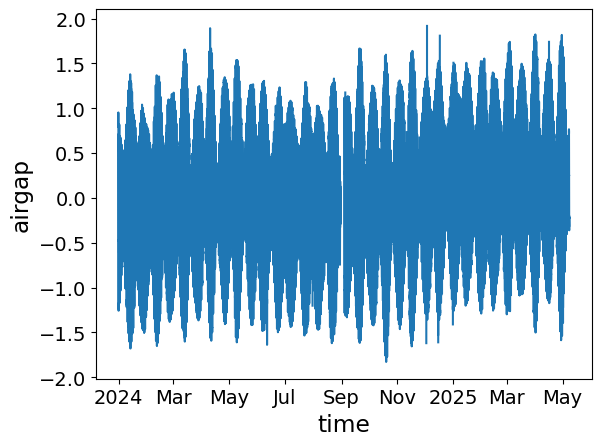

In [34]:
# ds = xr.open_dataset(f'/data/TIDE/NRA/NRA_airgap_RAW_{year}_60s.nc')
# time = ds['Timestamp (UTC+8)'].values

# time_utc = time - np.timedelta64(8*3600, 's')

# dt = (time[1:]-time[:-1]).mean()
# dtsec = dt.astype(float)*1e-9

# # Important ssh = -1*airgap i.e. airgap grows when water level drops
# ssh  = -ds['airgap'] + ds['airgap'].mean()

# ssh = ssh.rename({'Timestamp (UTC+8)':'time'})
# ssh['time'] = time_utc

# ssh.plot()
# ssh